In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, mutual_info_regression
from statsmodels.tsa.api import VAR, DynamicVAR

C:\Users\soloc\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
energydata = pd.DataFrame.from_csv('./energydata_complete.csv', index_col=None, encoding="utf-8")
energydata["date"] = pd.to_datetime(energydata.date)
energydata["consumedE"] = energydata["Appliances"]+energydata["lights"]
energydata = energydata[(energydata.date>=pd.to_datetime("2016-01-12")) & (energydata.date<pd.to_datetime("2016-05-27"))]
#energydata.head()

In [3]:
energydata.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,consumedE
count,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,...,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000
mean,97.396344,3.763276,21.673039,40.212379,20.319462,40.394346,22.245344,39.219290,20.837798,38.983193,...,41.518732,7.360404,755.564782,79.760442,4.046492,38.279437,3.712474,24.983413,24.983413,101.159620
std,102.276678,7.842493,1.597255,3.954105,2.176298,4.070266,1.977770,3.248381,2.030943,4.325417,...,4.149146,5.279851,7.367592,14.917120,2.453617,11.756823,4.161938,14.500737,14.500737,104.114204
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,50.000000,0.000000,20.730000,37.326667,18.790000,37.863333,20.790000,36.884286,19.500000,35.500000,...,38.500000,3.633333,750.933333,70.333333,2.000000,29.000000,0.900000,12.486373,12.486373,50.000000
50%,60.000000,0.000000,21.600000,39.590000,20.000000,40.466667,22.100000,38.500000,20.633333,38.400000,...,40.837857,6.900000,756.116667,83.666667,3.666667,40.000000,3.400000,24.891900,24.891900,60.000000
75%,100.000000,0.000000,22.600000,42.966667,21.500000,43.210714,23.290000,41.730000,22.100000,42.030000,...,44.252071,10.350000,761.000000,91.666667,5.500000,40.000000,6.500000,37.586778,37.586778,100.000000
max,1080.000000,50.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000


# Change in granularity

In [4]:
dfdate = energydata.set_index("date")
dfdate = dfdate.resample('H').mean()

In [5]:
dfdate = dfdate.drop(["Appliances","lights"], axis = 1)

In [6]:
dfdate.describe()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,consumedE
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,...,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,21.673039,40.212379,20.319462,40.394346,22.245344,39.219290,20.837798,38.983193,19.578744,50.913567,...,41.518732,7.360404,755.564782,79.760442,4.046492,38.279437,3.712474,24.983413,24.983413,101.159620
std,1.596212,3.916452,2.171841,4.054460,1.975911,3.238923,2.028330,4.320139,1.831218,8.646427,...,4.140844,5.273695,7.367658,14.843258,2.433606,11.170744,4.157021,5.951300,5.951300,83.020902
min,16.790000,27.509167,16.100000,21.010000,17.245000,29.700556,15.100000,28.715571,15.347500,30.188611,...,29.218889,-4.961111,729.383333,25.250000,0.416667,1.000000,-6.475000,5.259551,5.259551,28.333333
25%,20.740556,37.320972,18.817222,37.892326,20.790000,36.865228,19.544444,35.500156,18.259931,45.451944,...,38.500000,3.647917,750.916667,70.479167,2.000000,31.833333,0.906250,20.734102,20.734102,51.666667
50%,21.590278,39.606944,19.968333,40.467424,22.100000,38.515278,20.638889,38.381343,19.383095,49.161759,...,40.806944,6.887500,756.141667,83.666667,3.583333,40.000000,3.391667,24.943998,24.943998,66.666667
75%,22.611111,43.015660,21.470417,43.227333,23.290000,41.740556,22.089167,42.006215,20.607609,53.822106,...,44.250625,10.370833,760.983333,91.583333,5.416667,40.000000,6.485417,29.101986,29.101986,116.666667
max,26.203333,53.980139,29.727778,53.914975,28.975286,49.472222,26.144762,50.747222,25.506389,94.884074,...,53.140000,25.933333,772.258333,100.000000,13.000000,66.000000,15.250000,43.611051,43.611051,623.333333


# Dickey-Fuller Test

In [7]:
from statsmodels.tsa.stattools import adfuller
plt.style.use('classic')

def test_stationarity(timeseries,counts):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=counts)
    rolstd = pd.rolling_std(timeseries, window=counts)

    #Plot rolling statistics:
    plt.xticks(rotation=45)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    #plt.title('Rolling Mean & Standard Deviation')
    #plt.show(block=False)
    plt.savefig('Dickey-Fuller.eps', format='eps', dpi=1000)
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\soloc\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  import sys
C:\Users\soloc\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  


Results of Dickey-Fuller Test:
Test Statistic                -8.257370e+00
p-value                        5.193399e-13
#Lags Used                     2.700000e+01
Number of Observations Used    3.236000e+03
Critical Value (1%)           -3.432372e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64


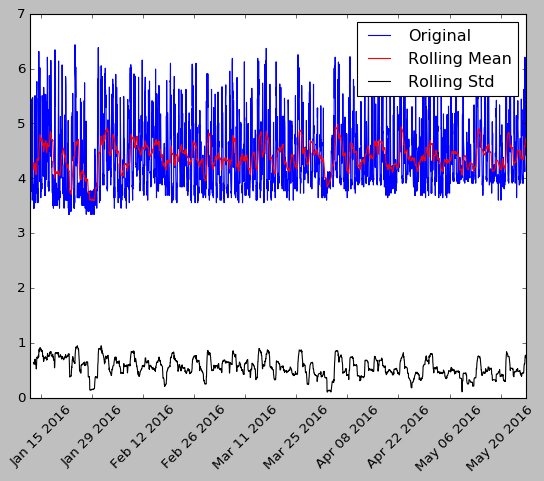

In [8]:
test_stationarity(np.log(dfdate.consumedE),24)

# Feature Reduction
## mutual_info

In [9]:
midate = mutual_info_regression(dfdate.loc[:, dfdate.columns != 'consumedE'], dfdate.consumedE)
midate /= np.max(midate)

In [10]:
mean_midate = sum(midate)/len(midate)
mean_midate

0.48232839606663769

In [11]:
midatefeatures = pd.DataFrame(list(zip(dfdate.loc[:, dfdate.columns != 'consumedE'], midate)), columns = ["name", 'miCoefficient'])
midatefeatures[midatefeatures.miCoefficient > mean_midate]

,name,miCoefficient
0,T1,0.738690
1,RH_1,0.541295
2,T2,0.498392
4,T3,0.811576
5,RH_3,0.569072
6,T4,0.852033
8,T5,0.837221
11,RH_6,0.674867
12,T7,0.870355
14,T8,0.809254


In [12]:
midatefeatures = midatefeatures[midatefeatures.miCoefficient < mean_midate]
dfdate = dfdate.drop(list(midatefeatures.name.values), axis = 1)
dfdate = np.log(dfdate)
dfdate.describe()

,T1,RH_1,T2,T3,RH_3,T4,T5,RH_6,T7,T8,T9,RH_9,consumedE
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,3.073350,3.689505,3.006120,3.098244,3.665821,3.032016,2.970171,3.599507,3.002908,3.088136,2.963776,3.721240,4.393164
std,0.073876,0.096378,0.103480,0.087977,0.081493,0.097713,0.092030,1.240749,0.103213,0.090401,0.101927,0.098810,0.617086
min,2.820783,3.314519,2.778819,2.847522,3.391166,2.714695,2.730953,0.000000,2.735041,2.795088,2.700690,3.374815,3.344039
25%,3.032091,3.619555,2.934773,3.034472,3.607269,2.972691,2.904709,3.410487,2.929236,3.034359,2.891606,3.650658,3.944813
50%,3.072243,3.679004,2.994148,3.095578,3.651055,3.027177,2.964401,4.012381,2.997467,3.097060,2.964757,3.708852,4.199705
75%,3.118441,3.761564,3.066676,3.148024,3.731473,3.095087,3.025660,4.422512,3.072693,3.151262,3.024212,3.789869,4.759321
max,3.265887,3.988616,3.392082,3.366443,3.901411,3.263649,3.238929,4.604170,3.255272,3.302768,3.198673,3.972930,6.435081


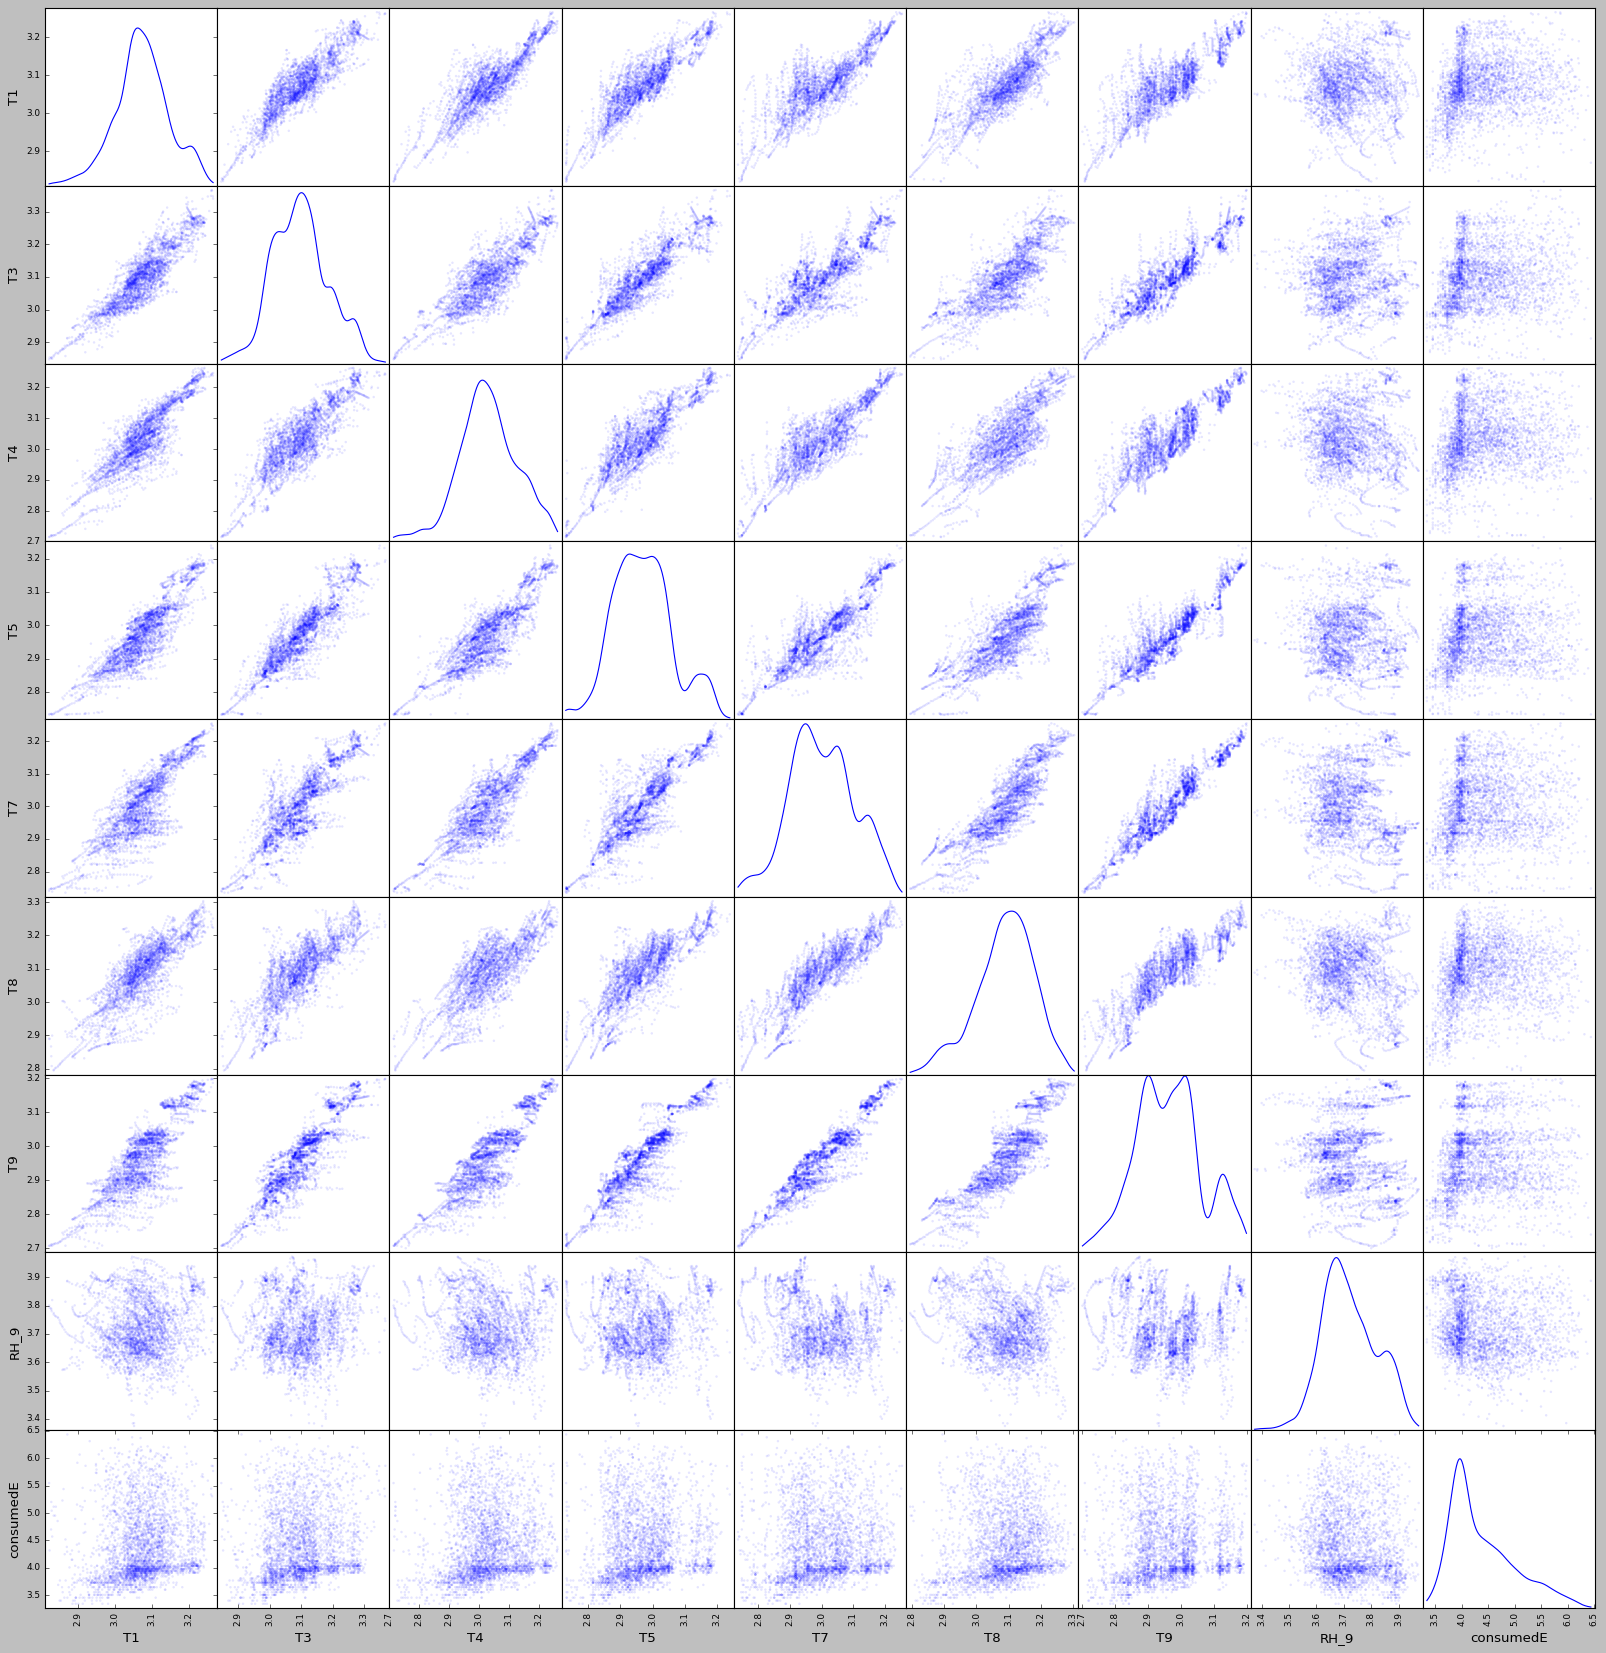

In [13]:
plt.style.use('classic')
plt.figure()
axs = scatter_matrix(dfdate[["T1","T3","T4","T5","T7","T8","T9","RH_9","consumedE"]],alpha=0.1
                     ,diagonal='kde',figsize=(25,25))
plt.savefig('scatter-matrix.eps', format='eps', dpi=100)

In [14]:
dfdate.min()

T1           2.820783
RH_1         3.314519
T2           2.778819
T3           2.847522
RH_3         3.391166
T4           2.714695
T5           2.730953
RH_6         0.000000
T7           2.735041
T8           2.795088
T9           2.700690
RH_9         3.374815
consumedE    3.344039
dtype: float64

In [15]:
max_lag = 80
errorvalue = np.zeros((max_lag-1,2))
for i in range(1,max_lag):
    model = VAR(dfdate)
    results = model.fit(i)
    final = pd.DataFrame(dfdate.consumedE)
    final["fitted"] = results.fittedvalues.consumedE
    final = final.dropna()
    final["error"] = np.abs(final.fitted - final.consumedE)/final.consumedE
    errorvalue[i-1,0] = int(i)
    errorvalue[i-1,1] = final.error.mean()*100

    df=pd.DataFrame(dfdate.consumedE)
    df["fitted"]=results.fittedvalues.consumedE
    df = df.dropna()
    #df[["consumedE","fitted"]].plot(figsize=(15, 3),title="lag = %s , error = %s"%(i,final.error.mean()*100))

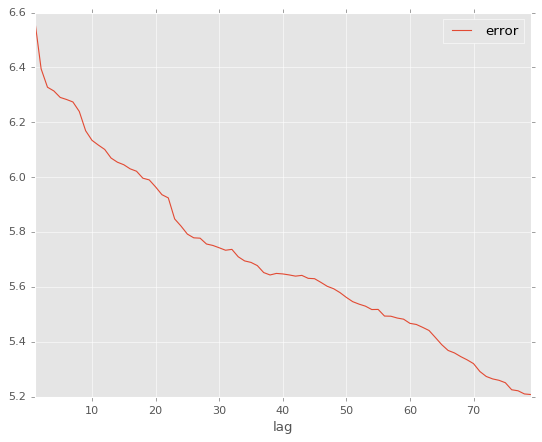

In [16]:
errorplt = pd.DataFrame(errorvalue,columns=["lag","error"])
errorplt = errorplt.set_index("lag")
plt.style.use('ggplot')
errorplt.plot()

# Cross validation

I will divide the data in two parts, one I wiill use t for train and the other part for test.
As I already defined dfdate and I filtered the most related features, I will use it for the cross validation.

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [18]:
final_test = dfdate.reset_index()
final_test.date = pd.to_datetime(final_test.date)
final_test = final_test[final_test.date >= pd.to_datetime("2016-05-10")]
final_test = final_test.set_index("date")

train_set = dfdate.reset_index()
train_set.date = pd.to_datetime(train_set.date)
#train_set = train_set[train_set.date < pd.to_datetime("2016-05-10")]
train_set = train_set.set_index("date")

In [19]:
tscv = TimeSeriesSplit( n_splits=int(len(train_set)/25) )
max_lag = 72
errors = []
for i in range(1,max_lag+1):
    hypothesisresults = []
    split = 0
    for train, test in tscv.split(train_set):
        model = VAR(train_set.iloc[train])
        results = model.fit(i)
        final = pd.DataFrame(results.forecast(train_set.iloc[train].values[-i:], len(test)),columns=train_set.columns.values )
        final["consumedE_file"] = train_set.consumedE[test].values
        final["date"] = train_set.index[test].values
        final["error"] =  np.abs(final.consumedE-final.consumedE_file)/final.consumedE_file
    hypothesisresults.append(final.error.mean())
    errors.append( hypothesisresults  )
print(len(test))

24


In [20]:
errors= np.asarray(errors)
errors = pd.DataFrame(errors,columns=["error"])
errors.index +=1
errors[errors.error==errors.error.min()]

,error
29,0.089536


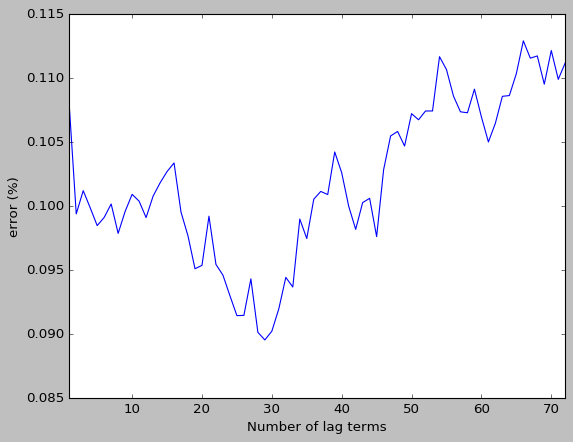

In [21]:
plt.style.use('classic')

errors.error = errors.error
ax = errors.plot(c="blue",legend=False)
ax.set_xlabel("Number of lag terms")
ax.set_ylabel("error (%)")
plt.savefig('error.eps', format='eps', dpi=1000)

In [22]:
i = 29
model = VAR(dfdate)
results = model.fit(i)

In [23]:
period = 24*4
forecast = pd.DataFrame(results.forecast(dfdate.values[-results.k_ar:], period),columns=train_set.columns.values )
forecast["date"] = pd.Series(pd.date_range('2016-5-27', periods=period, freq='H'))
forecast = forecast.set_index("date")

In [74]:
RF = pd.DataFrame.from_csv('./forecast_energy.csv', index_col=None, encoding="utf-8")
RF["date"] = pd.to_datetime(RF.date)
RF = RF[(RF.date>=pd.to_datetime("2016-05-27"))]
RF = RF.set_index("date")

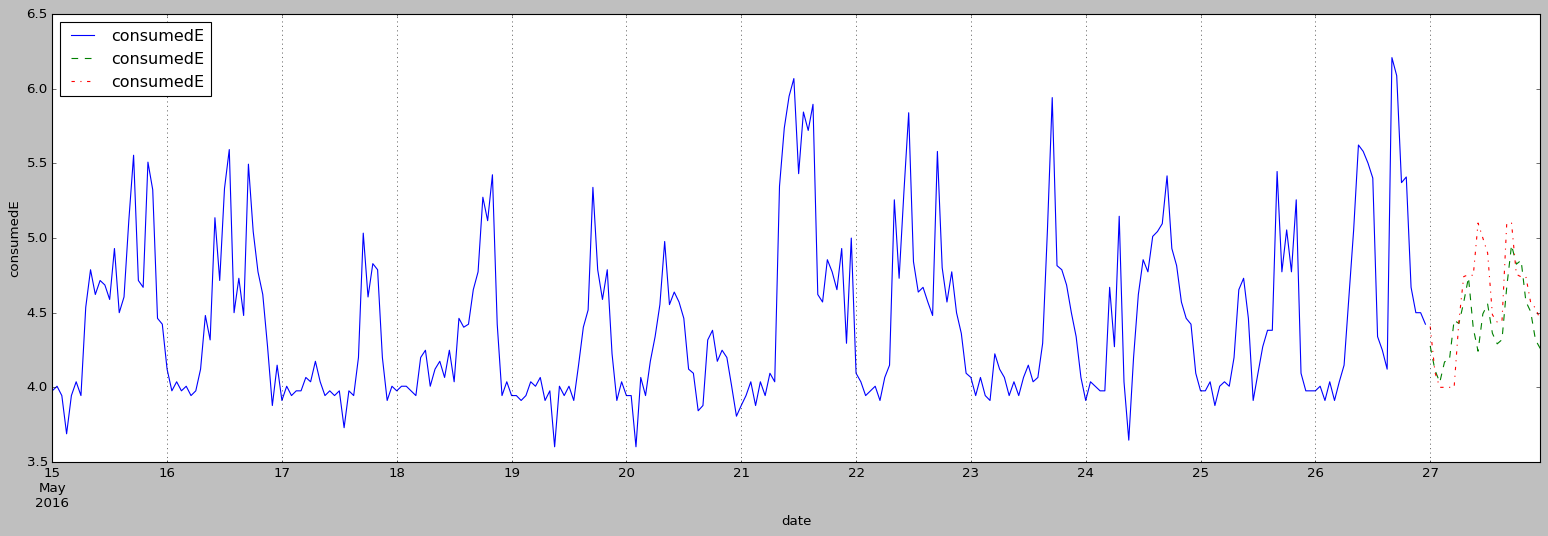

In [93]:
ax = dfdate[dfdate.index>=pd.to_datetime("2016-05-15")].consumedE.plot(figsize=(24,7),legend="data")
forecast[forecast.index<pd.to_datetime("2016-05-28")].consumedE.plot(ax=ax,legend="forecast",linestyle="--")
newRF.consumedE.plot(ax=ax,legend="forecast",linestyle="-.")
ax.grid('on', which='minor', axis='x' )
ax.set_ylabel("consumedE")
plt.savefig('forecast.eps', format='eps', dpi=1000)

In [50]:
RF

,T1t-24,T1t-23,T1t-22,T1t-21,T1t-20,T1t-19,T1t-18,T1t-17,T1t-16,T1t-15,...,consumedEt-9,consumedEt-8,consumedEt-7,consumedEt-6,consumedEt-5,consumedEt-4,consumedEt-3,consumedEt-2,consumedEt-1,consumedE
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 00:00:00,3.182077,3.179163,3.176239,3.173308,3.170367,3.167418,3.164461,3.161742,3.160776,3.160835,...,4.121744,6.207919,6.086775,5.370638,5.408665,4.669709,4.499810,4.499810,4.422849,4.407020
2016-05-27 01:00:00,3.179163,3.176239,3.173308,3.170367,3.167418,3.164461,3.161742,3.160776,3.160835,3.161482,...,6.207919,6.086775,5.370638,5.408665,4.669709,4.499810,4.499810,4.422849,4.407020,4.436488
2016-05-27 02:00:00,3.176239,3.173308,3.170367,3.167418,3.164461,3.161742,3.160776,3.160835,3.161482,3.169756,...,6.086775,5.370638,5.408665,4.669709,4.499810,4.499810,4.422849,4.407020,4.436488,4.439097
2016-05-27 03:00:00,3.173308,3.170367,3.167418,3.164461,3.161742,3.160776,3.160835,3.161482,3.169756,3.179881,...,5.370638,5.408665,4.669709,4.499810,4.499810,4.422849,4.407020,4.436488,4.439097,4.442847
2016-05-27 04:00:00,3.170367,3.167418,3.164461,3.161742,3.160776,3.160835,3.161482,3.169756,3.179881,3.186353,...,5.408665,4.669709,4.499810,4.499810,4.422849,4.407020,4.436488,4.439097,4.442847,4.437430
2016-05-27 05:00:00,3.167418,3.164461,3.161742,3.160776,3.160835,3.161482,3.169756,3.179881,3.186353,3.186353,...,4.669709,4.499810,4.499810,4.422849,4.407020,4.436488,4.439097,4.442847,4.437430,4.439005
2016-05-27 06:00:00,3.164461,3.161742,3.160776,3.160835,3.161482,3.169756,3.179881,3.186353,3.186353,3.186353,...,4.499810,4.499810,4.422849,4.407020,4.436488,4.439097,4.442847,4.437430,4.439005,4.443863
2016-05-27 07:00:00,3.161742,3.160776,3.160835,3.161482,3.169756,3.179881,3.186353,3.186353,3.186353,3.189767,...,4.499810,4.422849,4.407020,4.436488,4.439097,4.442847,4.437430,4.439005,4.443863,4.741511
2016-05-27 08:00:00,3.160776,3.160835,3.161482,3.169756,3.179881,3.186353,3.186353,3.186353,3.189767,3.194173,...,4.422849,4.407020,4.436488,4.439097,4.442847,4.437430,4.439005,4.443863,4.741511,4.754018
